In [1]:
!pip3 install transformers
!pip3 install torch

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHNHm4OfbjkxEXXa51JwZEHAaDlvfSgN0OU256...,Lex S,https://lh3.googleusercontent.com/-FgDpDeEJLAw...,"I love this app, but I do have one major gripe...",1,3,5.2.0.23,2020-08-05 16:22:04,Any.do is not only a product but also a servic...,2020-08-05 08:02:08,most_relevant,com.anydo
1,gp:AOqpTOEujjLj56XVqumAkipImEqIAU3qTIuQjENPaOK...,Sam van Dijk,https://lh3.googleusercontent.com/-pO3wTIb4myA...,"Trash. Yes, it has some nice nifty features bu...",1,25,5.2.0.23,2020-07-21 22:17:25,"Premium users can edit, create and delete tags...",2020-07-23 15:57:51,most_relevant,com.anydo
2,gp:AOqpTOElISilniODwd6UBrqFngzTtDHLF-G0VLpR2_y...,Hugo Bounoua,https://lh3.googleusercontent.com/a-/AOh14GgxG...,"OMG the UI is awful, seriously you have popup ...",1,8,5.2.0.23,2020-07-22 07:23:35,The Premium ad only shows up when first openin...,2020-07-23 16:20:43,most_relevant,com.anydo
3,gp:AOqpTOEkZ75JR5CzVhxoxWa0XVmPanw_pEl1srcJ7yv...,Aishwarya Mishra,https://lh3.googleusercontent.com/a-/AOh14Ghhq...,I've been using the app for a while and since ...,1,20,5.2.0.23,2020-07-19 06:49:15,"Hi, due to new restrictions from Google, the p...",2020-07-22 14:05:56,most_relevant,com.anydo
4,gp:AOqpTOEtpLcODD_NZOBqR1N7DBbaLdw3Gyz3v3xZAp1...,Mad Scientist,https://lh3.googleusercontent.com/-kIZF4kMt6yY...,"Unable to register with an email. Clicking""con...",1,77,5.2.0.9,2020-07-10 17:59:22,We are unaware of any issues with signing in t...,2020-07-12 08:02:19,most_relevant,com.anydo


In [5]:
df.shape

(16092, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16092 entries, 0 to 16091
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16092 non-null  object
 1   userName              16092 non-null  object
 2   userImage             16092 non-null  object
 3   content               16092 non-null  object
 4   score                 16092 non-null  int64 
 5   thumbsUpCount         16092 non-null  int64 
 6   reviewCreatedVersion  13742 non-null  object
 7   at                    16092 non-null  object
 8   replyContent          7889 non-null   object
 9   repliedAt             7889 non-null   object
 10  sortOrder             16092 non-null  object
 11  appId                 16092 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


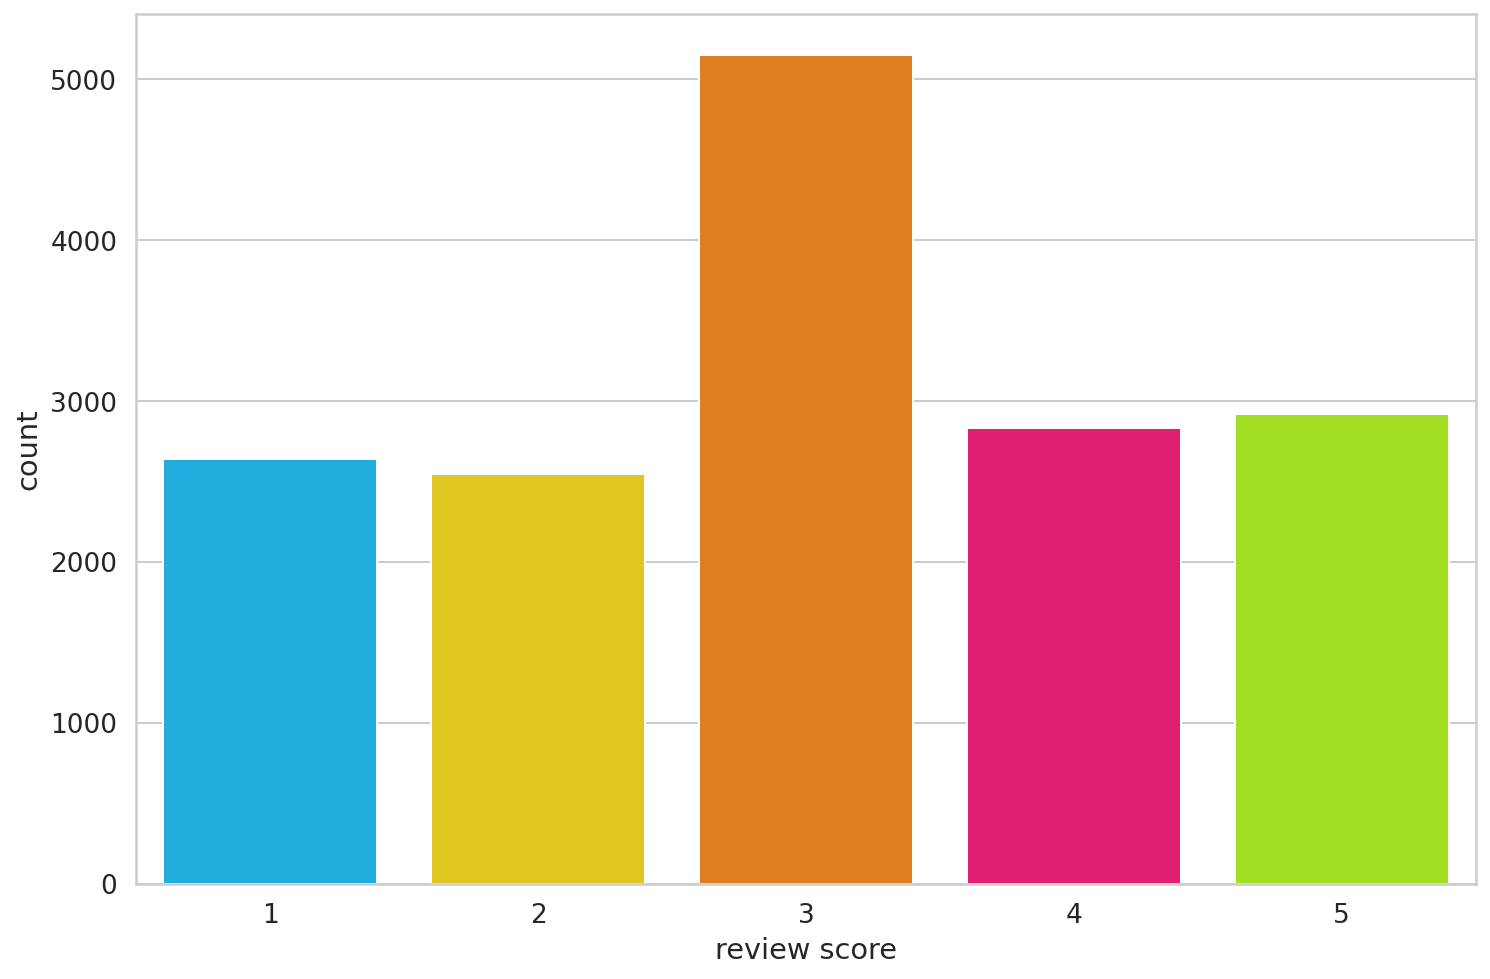

In [7]:
sns.countplot(df.score)
plt.xlabel('review score');

In [8]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
class_names = ['negative', 'neutral', 'positive']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


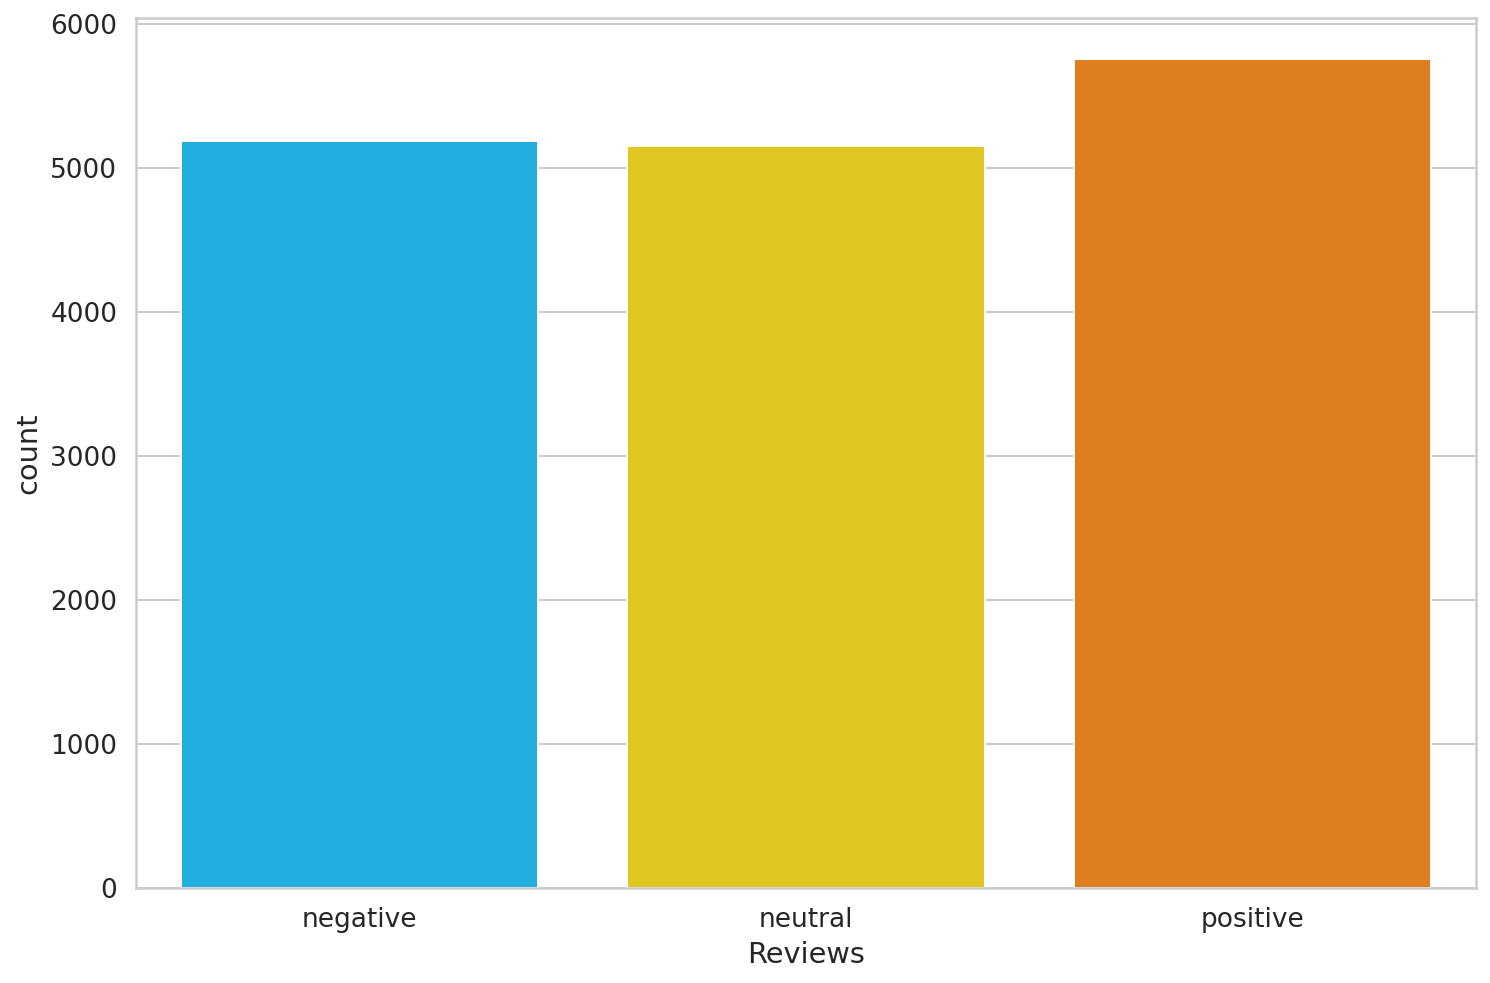

In [10]:
ax = sns.countplot(df.sentiment)
plt.xlabel("Reviews")
ax.set_xticklabels(class_names);

In [11]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
token_lens = []

for x in df.content:
    tokens = tokenizer.encode(x, max_length=512, truncation=True)
    token_lens.append(len(tokens))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token Count')

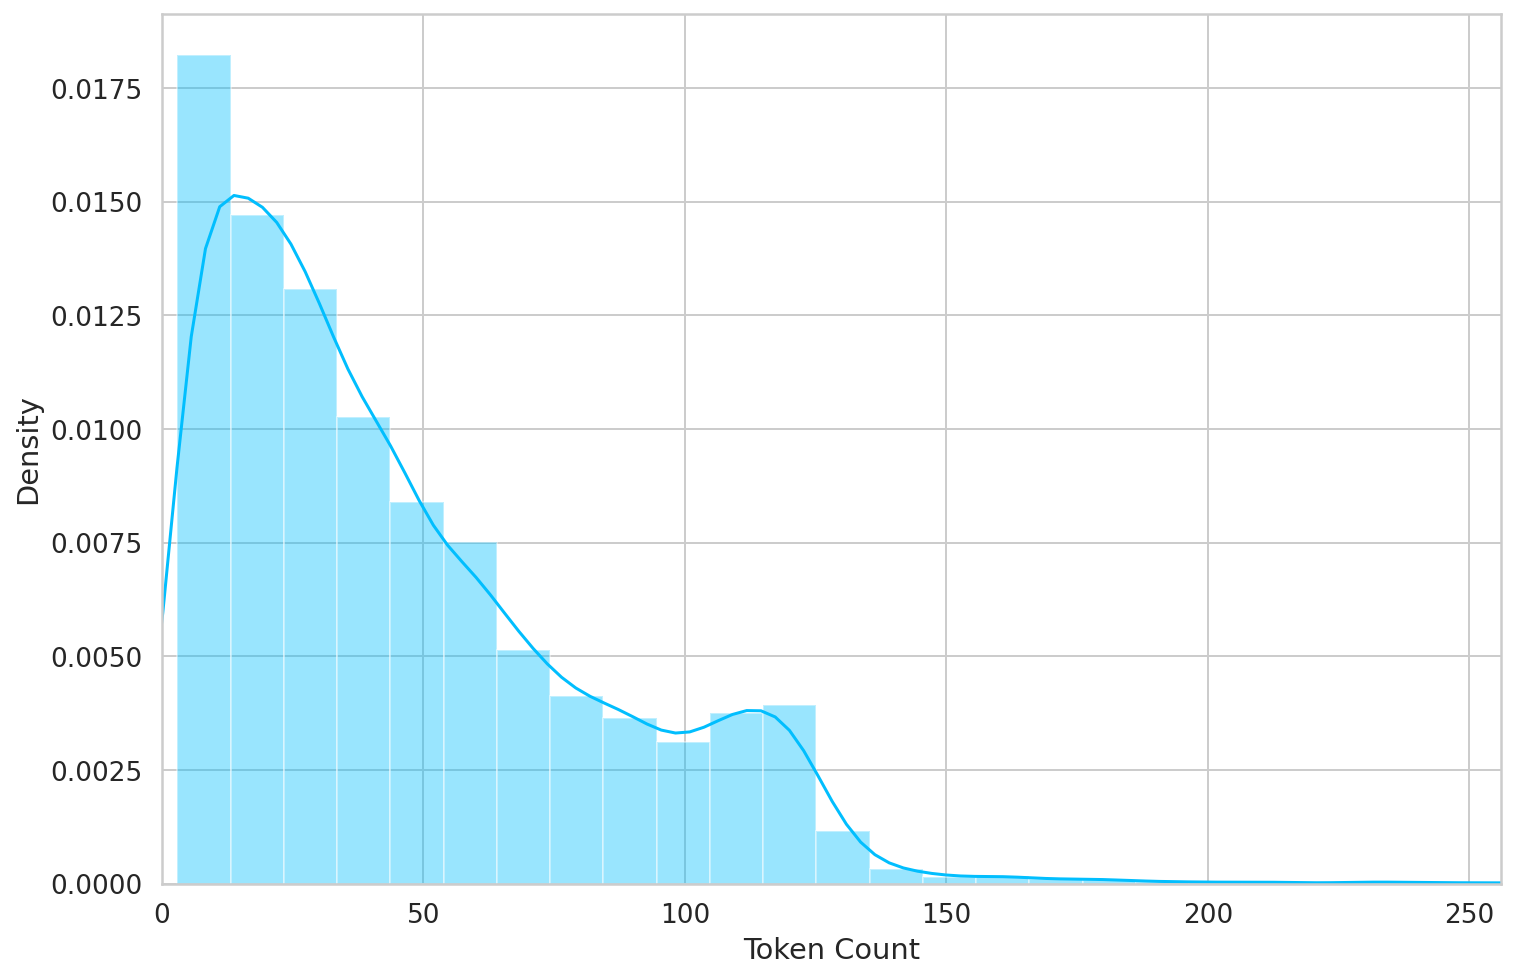

In [14]:
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel("Token Count")

In [15]:
MAX_LEN = 160

In [16]:
class GPReviewDataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(review, add_special_tokens = True, max_length = self.max_len, return_token_type_ids = False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt', truncation=True)
        
        return {"review_text": review, "input_ids": encoding["input_ids"].flatten(), "attention_mask": encoding["attention_mask"].flatten(), "targets": torch.tensor(target, dtype=torch.long)}
    

In [17]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(reviews=df.content.to_numpy(), targets=df.sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
    
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

In [19]:
BATCH_SIZE = 48

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, batch_size=BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
data = next(iter(train_data_loader))
print(len(data))
data.keys()

4


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [21]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask, return_dict=False):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        return  self.out(output)

In [22]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [23]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader)*EPOCHS

schedular = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, schedular, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        schedular.step()
        
        optimizer.zero_grad()
        
    return correct_predictions.double()/n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_exmaples):
    model = model.eval()
    
    losses = []
    
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, preds = torch.max(output, dim=1)
            
            loss = loss_fn(output, targets)
            
            correct_predictions += torch.sum(preds == targets)
            
            losses.append(loss.item()) 
            
    return correct_predictions.double()/n_exmaples, np.mean(losses)

In [26]:
import boto3
client = boto3.client('s3')

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, schedular, len(df_train))
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.7152497569062063 accuracy 0.6735257561110344
Val   loss 0.5968083493849811 accuracy 0.760248447204969

Epoch 2/5
----------
Train loss 0.4052978418027328 accuracy 0.8428393868250242
Val   loss 0.5292245377512539 accuracy 0.8099378881987578

Epoch 3/5
----------
Train loss 0.22085117078725472 accuracy 0.925217511393454
Val   loss 0.5606450920595842 accuracy 0.8372670807453416

Epoch 4/5
----------
Train loss 0.13592782604588283 accuracy 0.9539428255765778
Val   loss 0.608139603453524 accuracy 0.8596273291925466

Epoch 5/5
----------
Train loss 0.0982699529668748 accuracy 0.9665101505316945
Val   loss 0.651338566752041 accuracy 0.8509316770186336



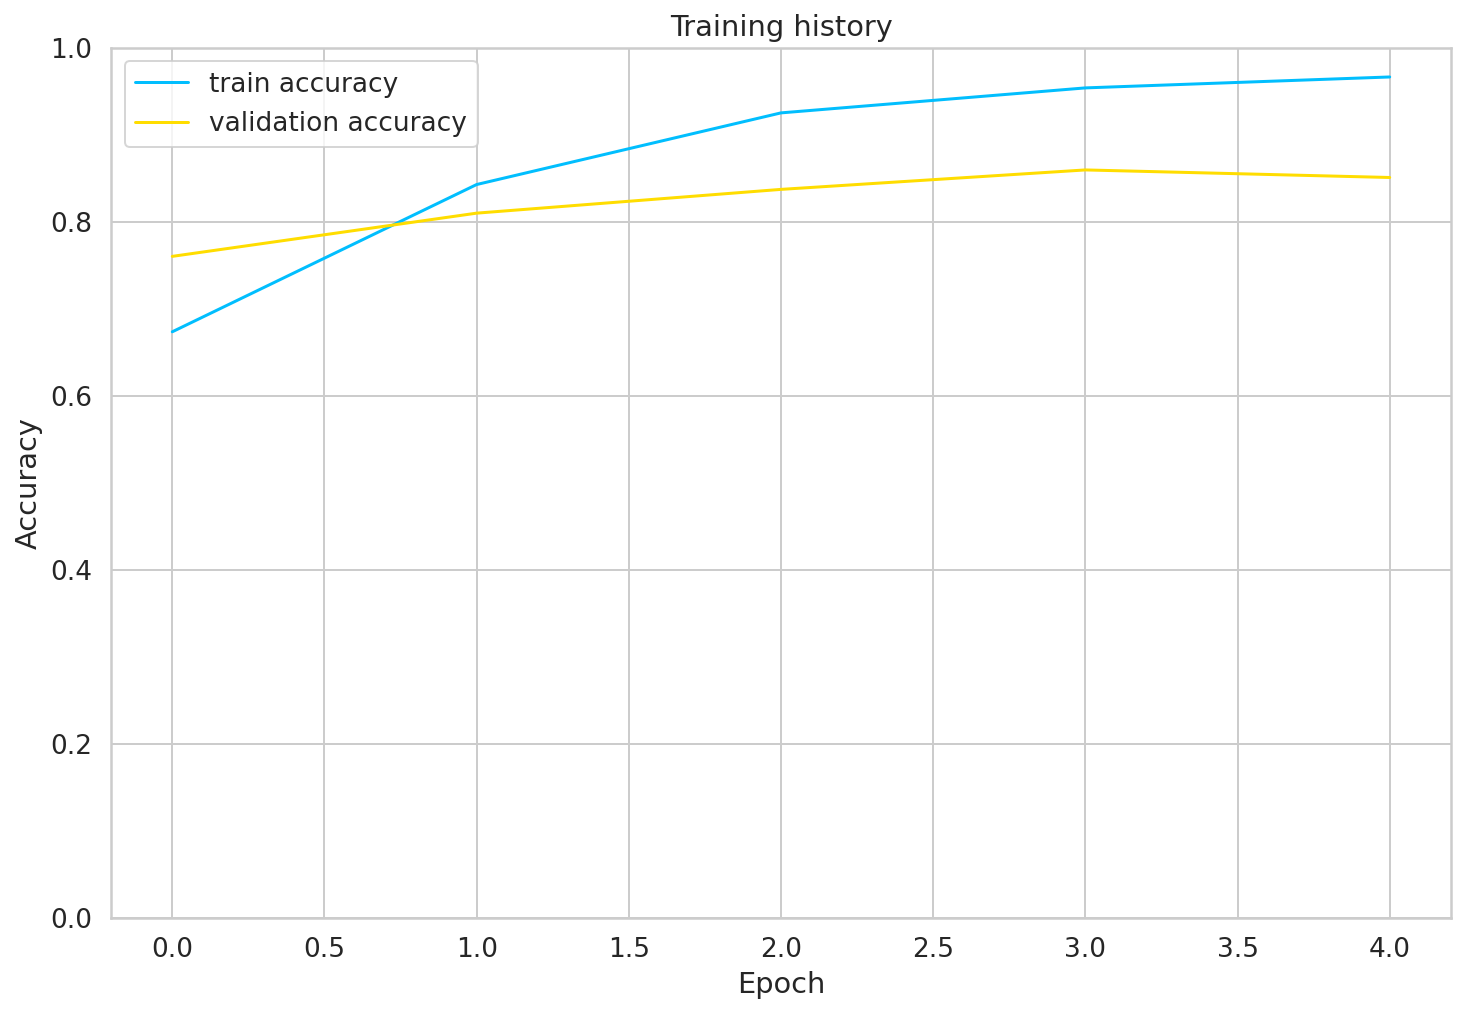

In [27]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.867080745341615

In [26]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            
            probs = F.softmax(outputs, dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values

In [40]:
y_review_texts, y_preds, y_probs, y_test = get_predictions(model, test_data_loader)

In [41]:
print(classification_report(y_test, y_preds, target_names = class_names))

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87       244
     neutral       0.78      0.87      0.82       250
    positive       0.93      0.88      0.91       311

    accuracy                           0.87       805
   macro avg       0.87      0.87      0.87       805
weighted avg       0.87      0.87      0.87       805



In [27]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

    plt.ylabel('True values')
    plt.xlabel('Predicted values')

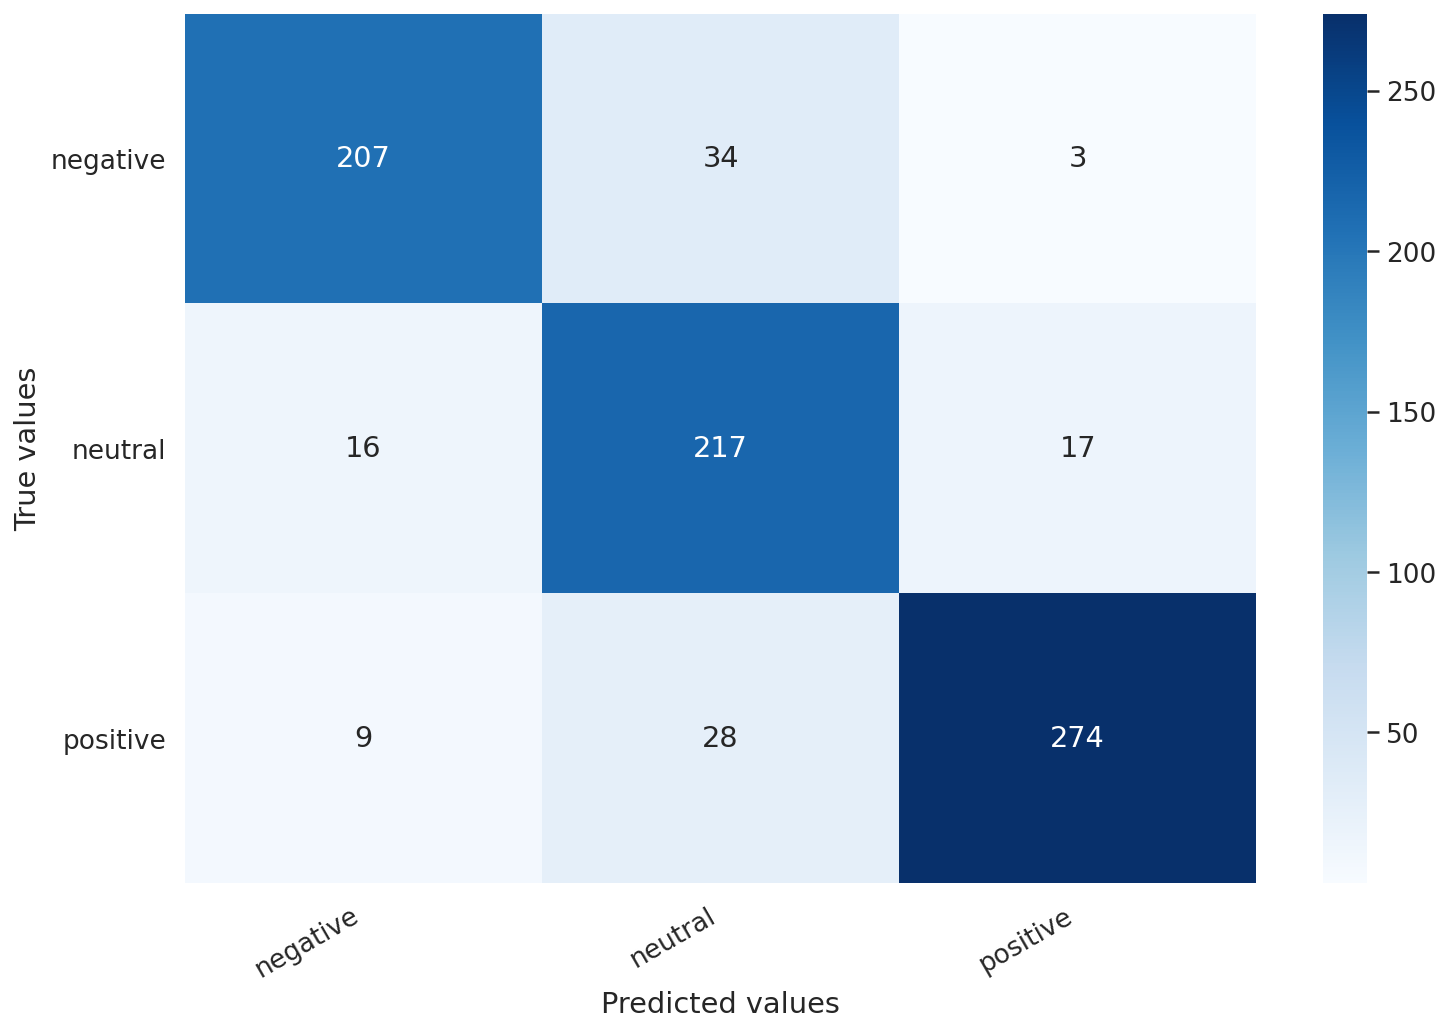

In [47]:
cm = confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [29]:
review_text = "I love completing my todos! Best app ever!!!"

In [30]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

In [65]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

pred = F.softmax(output, dim=1)
pred_vals = pred[0].cpu().detach().numpy()
pred_df = pd.DataFrame({'class_names': class_names, 'values': pred_vals})

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


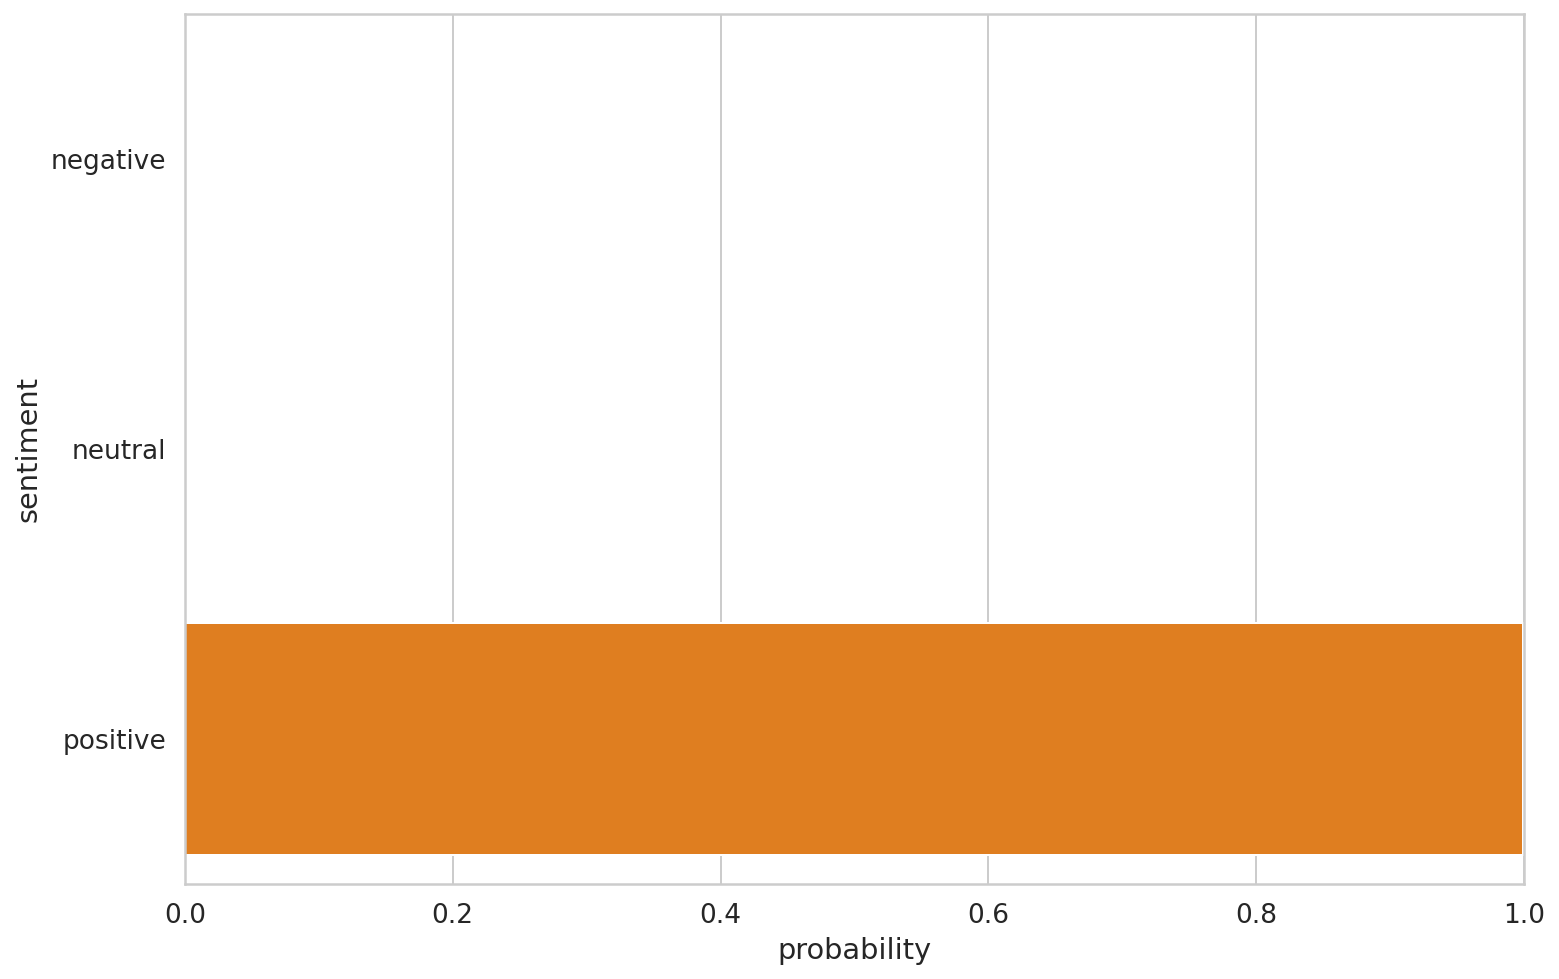

In [67]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

Loading the Model

In [28]:
new_model = SentimentClassifier(len(class_names))
new_model = new_model.to(device)

In [29]:
new_model.load_state_dict(torch.load('best_model_state.bin'))


<All keys matched successfully>

In [30]:
new_review_text = "The app is ok ok, not much to explain. I have seen better apps than this"
new_encodings = tokenizer.encode_plus(text=new_review_text, 
                                          max_length=MAX_LEN, 
                                          add_special_tokens=True, 
                                          return_token_type_ids=False, 
                                          padding=True,
                                          return_attention_mask=True, 
                                          return_tensors='pt',
                                          truncation=True)

In [31]:
new_input_ids = new_encodings['input_ids'].to(device)
new_attention_mask = new_encodings['attention_mask'].to(device)

new_output = new_model(input_ids=new_input_ids, attention_mask = new_attention_mask)
_, new_prediction = torch.max(new_output, dim=1)

new_probs = F.softmax(new_output, dim=1)
new_prob_values = new_probs[0].cpu().detach().numpy()
new_prob_df = pd.DataFrame({'class_names': class_names, 'values': new_prob_values})

print(f'Review text: {new_review_text}')
print(f'Sentiment  : {class_names[new_prediction]}')

Review text: The app is ok ok, not much to explain. I have seen better apps than this
Sentiment  : neutral


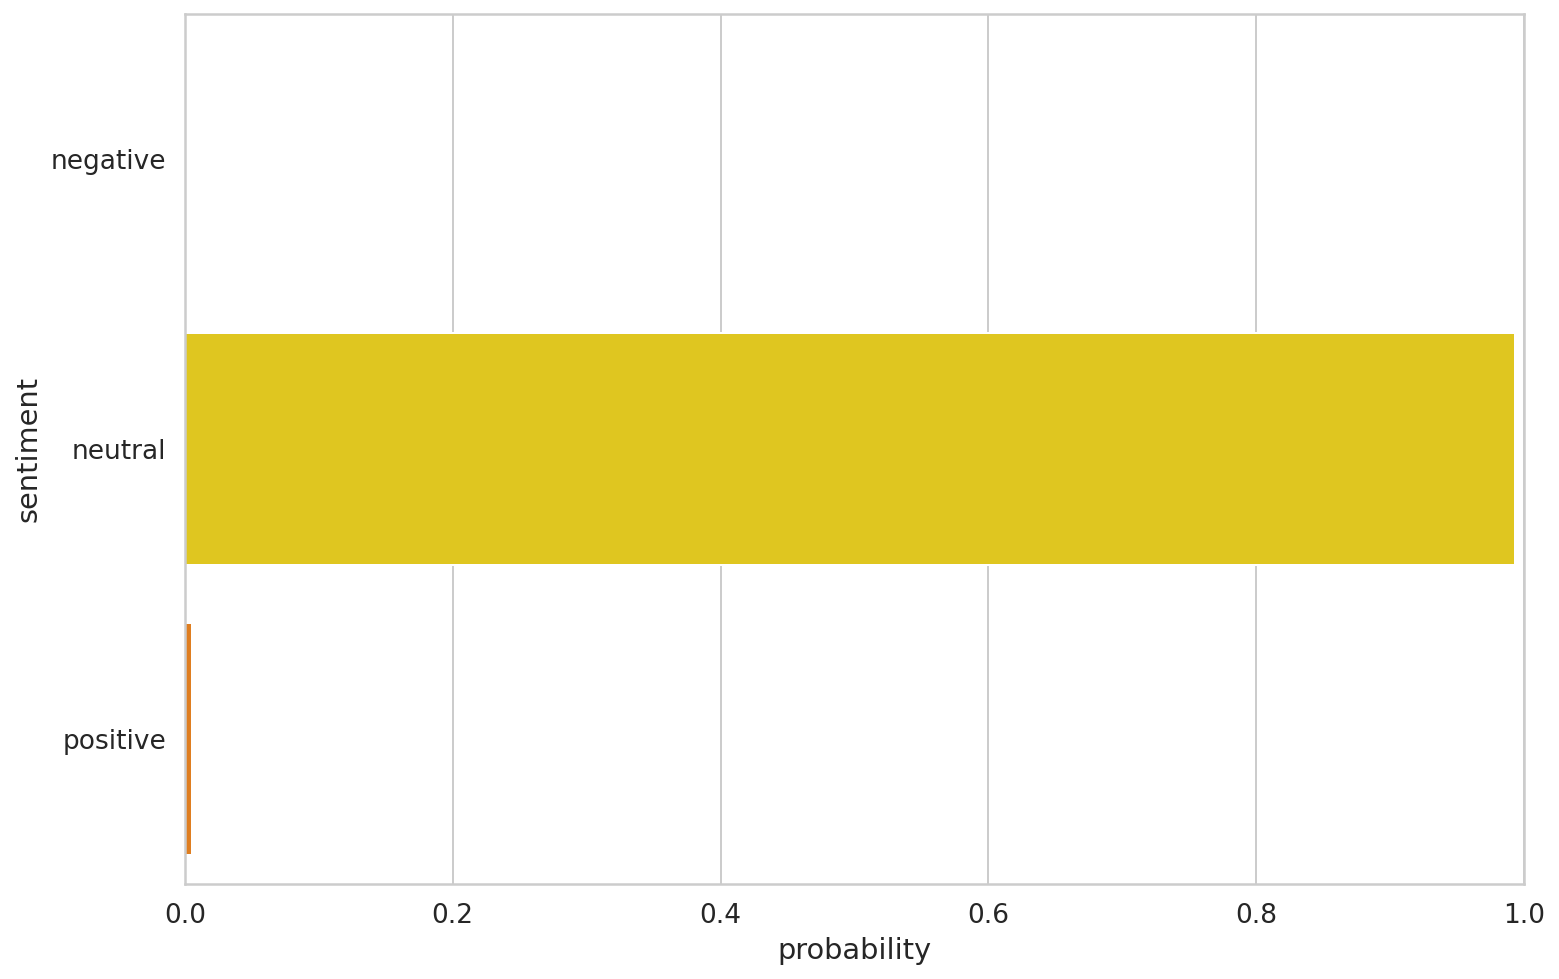

In [32]:
sns.barplot(x='values', y='class_names', data=new_prob_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [33]:
new_history = defaultdict(list)
new_best_accuracy = 0

for epoch in range(5, 10):
    print(f'Epoch {epoch + 1}/{10}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(new_model, train_data_loader, loss_fn, optimizer, device, schedular, len(df_train))
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(new_model, val_data_loader, loss_fn, device, len(df_val))
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    new_history['train_acc'].append(train_acc)
    new_history['train_loss'].append(train_loss)
    new_history['val_acc'].append(val_acc)
    new_history['val_loss'].append(val_loss)
    
    if val_acc > new_best_accuracy:
        torch.save(new_model.state_dict(), 'best_model_state.bin')
        new_best_accuracy = val_acc

Epoch 6/10
----------


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.09824060302363424 accuracy 0.9676149703079685
Val   loss 0.608139603453524 accuracy 0.8596273291925466

Epoch 7/10
----------
Train loss 0.09561449870319161 accuracy 0.9673387653639001
Val   loss 0.608139603453524 accuracy 0.8596273291925466

Epoch 8/10
----------
Train loss 0.09816224625278634 accuracy 0.9655434332274548
Val   loss 0.608139603453524 accuracy 0.8596273291925466

Epoch 9/10
----------
Train loss 0.09343106796446916 accuracy 0.9671316116558487
Val   loss 0.608139603453524 accuracy 0.8596273291925466

Epoch 10/10
----------
Train loss 0.09592906458130637 accuracy 0.9674078165999171
Val   loss 0.608139603453524 accuracy 0.8596273291925466



In [47]:
new_review_text2 = "This app is very disappointing but there are no pros. However, this is app is not the best"
new_encodings2 = tokenizer.encode_plus(text=new_review_text2, 
                                          max_length=MAX_LEN, 
                                          add_special_tokens=True, 
                                          return_token_type_ids=False, 
                                          padding=True,
                                          return_attention_mask=True, 
                                          return_tensors='pt',
                                          truncation=True)

In [48]:
new_input_ids2 = new_encodings2['input_ids'].to(device)
new_attention_mask2 = new_encodings2['attention_mask'].to(device)

new_output2 = new_model(input_ids=new_input_ids2, attention_mask = new_attention_mask2)
_, new_prediction2 = torch.max(new_output2, dim=1)

new_probs2 = F.softmax(new_output2, dim=1)
new_prob_values2 = new_probs2[0].cpu().detach().numpy()
new_prob_df2 = pd.DataFrame({'class_names': class_names, 'values': new_prob_values2})

print(f'Review text: {new_review_text2}')
print(f'Sentiment  : {class_names[new_prediction2]}')

Review text: This app is very disappointing but there are no pros. However, this is app is not the best
Sentiment  : negative


In [49]:
y_review_texts, y_preds, y_probs, y_test = get_predictions(new_model, test_data_loader)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [50]:
print(classification_report(y_test, y_preds, target_names = class_names))

              precision    recall  f1-score   support

    negative       0.90      0.85      0.87       244
     neutral       0.77      0.88      0.82       250
    positive       0.93      0.87      0.90       311

    accuracy                           0.86       805
   macro avg       0.87      0.86      0.86       805
weighted avg       0.87      0.86      0.87       805



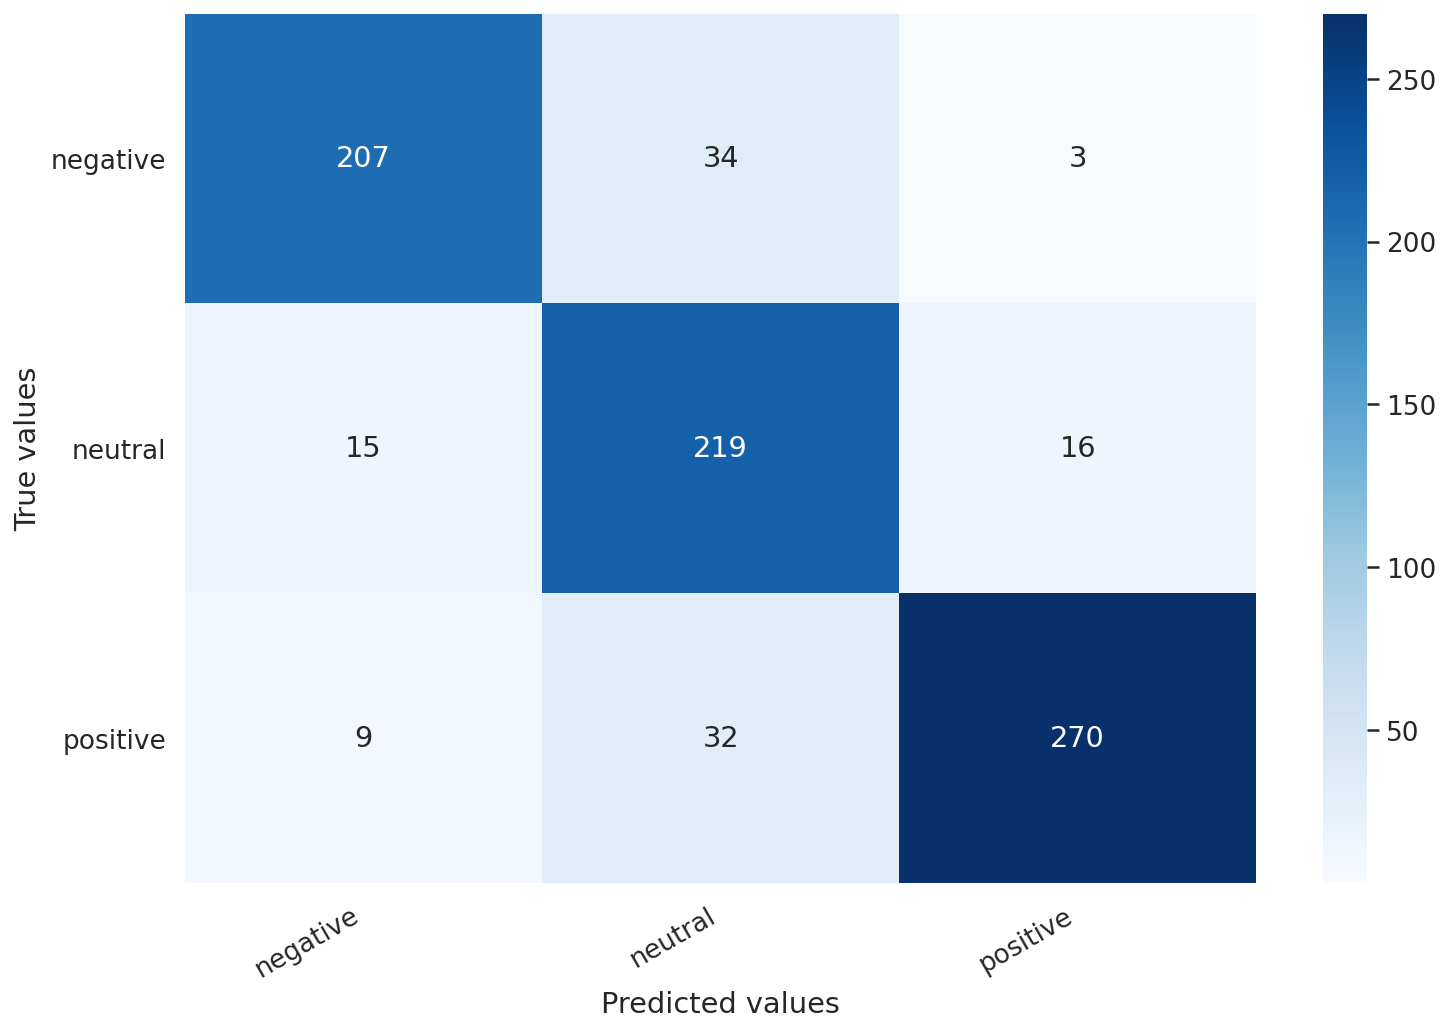

In [51]:
cm = confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)